In [1]:
import keras
from keras import layers
from random import uniform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def create_emoticon(emotion):
    img = np.zeros((64, 64), dtype=np.uint8)

    cv2.circle(img, (32, 32), 30, 255, 2)

    cv2.circle(img, (22, 24), 3, 255, -1)
    cv2.circle(img, (42, 24), 3, 255, -1)

    if emotion == "smile":
        cv2.ellipse(img, (32, 40), (12, 5), 0, 0, 180, 255, 2)
    elif emotion == "sad":
        cv2.ellipse(img, (32, 40), (12, 5), 0, 180, 360, 255, 2)
    elif emotion == "neutral":
        cv2.line(img, (22, 42), (42, 42), 255, 2)
    elif emotion == "surprise":
        cv2.circle(img, (32, 42), 5, 255, 2)
    else:
        raise ValueError(f"Unknown emotion: {emotion}")
    return img


def distort_image(img, noise_level=25, deform_shift=8):
    noisy = img.astype(np.float32)
    noisy += np.random.normal(0, noise_level, img.shape)
    noisy = np.clip(noisy, 0, 255)

    rows, cols = img.shape
    pts1 = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    pts2 = np.float32([[0, 0], [cols - 1, 0], [deform_shift, rows - 1]])
    M = cv2.getAffineTransform(pts1, pts2)
    warped = cv2.warpAffine(noisy, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return warped.astype(np.uint8)



In [ ]:
input_img = keras.Input(shape=(64, 64, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((4, 4), padding='same')(x)  # 64 -> 16
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)  # 16 -> 4
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((4, 4), padding='same')(x)  # 4 -> 1

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((4, 4))(x)  # 1 -> 4
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)  # 4 -> 16
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)  # 16 -> 64
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [4]:
db_labels = ["smile", "sad", "neutral", "surprise"] * 300
db_imgs = [
    distort_image(create_emoticon(emotion), uniform(16, 60), uniform(7, 20))
    for emotion in db_labels
]
x_train = np.array(db_imgs).astype('float32') / 255.0
x_train = x_train.reshape(-1, 64, 64, 1)

val_labels = ["smile", "sad", "neutral", "surprise"] * 50
val_imgs = [
    distort_image(create_emoticon(emotion), uniform(10, 40), uniform(3, 12))
    for emotion in val_labels
]

x_val = np.array(val_imgs).astype('float32') / 255.0
x_val = x_val.reshape(-1, 64, 64, 1)

print(f"Training dataset shape: {x_train.shape}")
print(f"Validation dataset shape: {x_val.shape}")

Training dataset shape: (1200, 64, 64, 1)
Validation dataset shape: (200, 64, 64, 1)


In [5]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, 
    batch_size=256, 
    shuffle=True,
    validation_data=(x_val, x_val)
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.1798 - val_loss: 0.1561
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.1798 - val_loss: 0.1561
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.1187 - val_loss: 0.1131
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.1187 - val_loss: 0.1131
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.1095 - val_loss: 0.1210
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.1095 - val_loss: 0.1210
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.1085 - val_loss: 0.1099
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.1085 - val_loss: 0.1099
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0996 - val_loss: 0.1111
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0996 - val_loss: 0.1111
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.1012 - val_loss: 0.1084
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.1012

In [6]:
test_img = create_emoticon("smile")
test_input = test_img.astype('float32') / 255.0
test_input = test_input.reshape(1, 64, 64, 1)

prediction = autoencoder.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


In [7]:
print("Input shape:", test_input.shape)
print("Prediction shape:", prediction.shape)

Input shape: (1, 64, 64, 1)
Prediction shape: (1, 64, 64, 1)


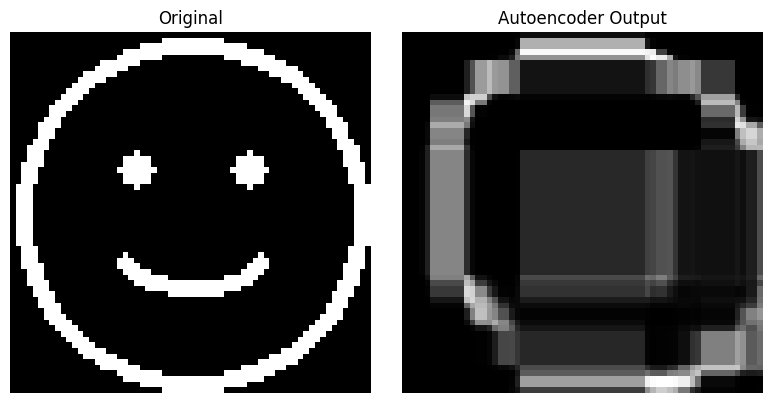

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(prediction[0, :, :, 0], cmap='gray')
axes[1].set_title('Autoencoder Output')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
encoder = keras.Model(input_img, encoded)

encoded_imgs = encoder.predict(x_val)
encoded_vectors = encoded_imgs.reshape(-1, 16)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [26]:
sample = encoded_vectors[0]

print("Encoded sample:")
print(f"- shape: {sample.shape}")
print(f"- vector: {list(map(float, sample))}")

Encoded sample:
- shape: (16,)
- vector: [16.177793502807617, 4.5904412269592285, 9.026464462280273, 8.482358932495117, 5.055552959442139, 2.2315874099731445, 2.0387728214263916, 0.0, 0.0, 3.8101589679718018, 4.578239917755127, 0.0, 0.0, 1.0386210680007935, 14.752584457397461, 9.996750831604004]


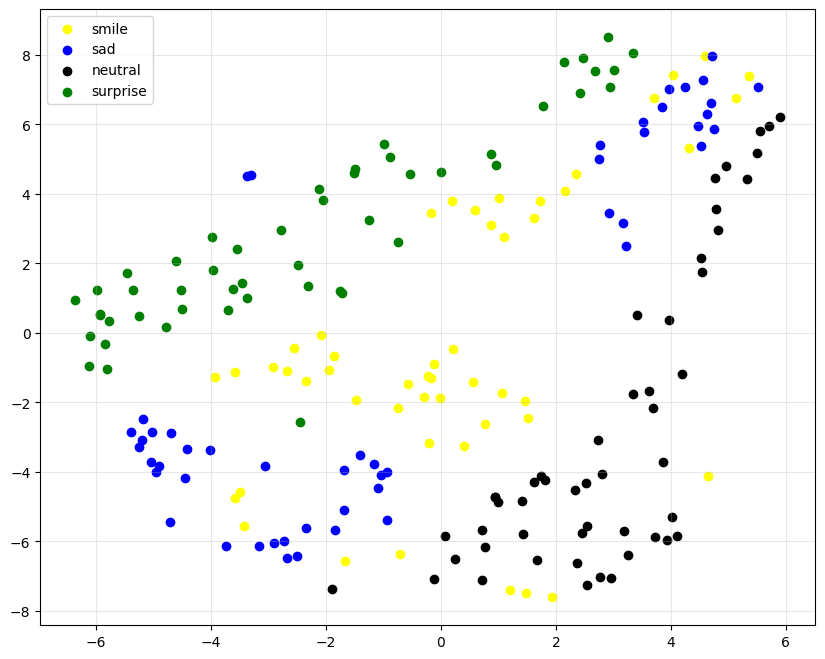

In [29]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
encoded_2d = tsne.fit_transform(encoded_vectors)
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'smile': 'yellow', 'sad': 'blue', 'neutral': 'black', 'surprise': 'green'}
for emotion in colors:
    idxs = [i for i, label in enumerate(val_labels) if label == emotion]
    ax.scatter(
        encoded_2d[idxs, 0], 
        encoded_2d[idxs, 1], 
        c=colors[emotion], 
        label=emotion, 
    )

ax.legend()
ax.grid(True, alpha=0.3)
plt.show()